#1.Giới thiệt dataset


> Đây là 1 file csv về các giá trị cổ phiếu của 1 cty MSN. Bao gồm các giá trị sau:


*   ***Date/Time***: ngày giờ của giá cổ phiếu
*   ***Open***: giá mở cửa
*   ***High***: Là giá cao nhất của cổ phiếu trong khoảng thời gian cụ thể (ví dụ, ngày, giờ, phút).
*   ***Low***:Là giá thấp nhất của cổ phiếu trong khoảng thời gian.
*   ***Close***:Là giá của cổ phiếu tại thời điểm cuối cùng của khoảng thời gian đó.
*   ***Volume***:Là tổng số cổ phiếu đã được giao dịch trong khoảng thời gian.





##1.2 Bài toán cần giải quyết
Xây dựng một số mô hình dự đoán biến động giá cổ phiếu.

Biến động giá cổ phiếu = Giá cổ phiếu N (phút hoặc giờ hoặc ngày) sau - Giá cổ phiếu hiện tại.

# 2.Import các thư viện cho bài toán này

In [1]:

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


import math
import random
import datetime as dt
import matplotlib.dates as mdates


import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

##2.1 Download data từ drive

In [2]:
%%shell

pip -q install --upgrade --no-cache-dir gdown
gdown --q 14l0ZEJFrFGwIktnLE6JybBF09-EUTZcA # csv file
echo 'download: done => file: MSN.csv'
rm -rf ./MSN/

download: done => file: MSN.csv


##2.2 Đọc file csv

In [3]:
df = pd.read_csv('/content/MSN.csv', parse_dates=['Date/Time'])
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,MSN,2017-12-25 09:15:00,73.1,73.1,73.1,73.1,4210,0
1,MSN,2017-12-25 09:16:00,73.0,73.0,73.0,73.0,5000,0
2,MSN,2017-12-25 09:18:00,73.5,73.5,73.5,73.5,210,0
3,MSN,2017-12-25 09:20:00,73.2,73.5,73.1,73.1,2050,0
4,MSN,2017-12-25 09:21:00,73.0,73.0,73.0,73.0,1380,0


In [4]:
# bỏ cột không cần thiết cho bài toán
df.drop(['Open Interest'], axis=1, inplace=True)

# 3.Explorartory Data Analysis

## 3.1 Preprocessing

In [5]:
# Calling our function
specific_df = df

In [6]:
specific_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135354 entries, 0 to 135353
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Ticker     135354 non-null  object        
 1   Date/Time  135354 non-null  datetime64[ns]
 2   Open       135354 non-null  float64       
 3   High       135354 non-null  float64       
 4   Low        135354 non-null  float64       
 5   Close      135354 non-null  float64       
 6   Volume     135354 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 7.2+ MB


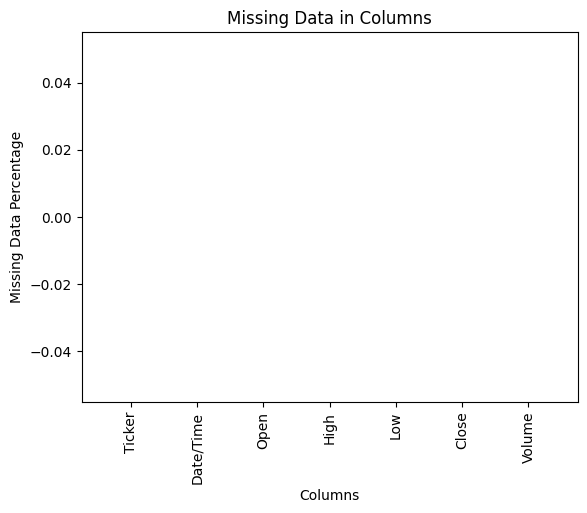

In [7]:
#kiếm tra xem dữ liệu có bị mising không
columns = []
missing_percentages = []
for col in specific_df.columns:
    missing_data = specific_df[col].isna().sum()
    missing_percentage = missing_data / len(specific_df) * 100
    columns.append(col)
    missing_percentages.append(missing_percentage)

plt.bar(columns, missing_percentages)
plt.xlabel('Columns')
plt.ylabel('Missing Data Percentage')
plt.title('Missing Data in Columns')
plt.xticks(rotation=90)
plt.show()

Như ta thấy kết quả ở trên dữ liệu không có missing nên ta có thể qua các bước tiếp theo

In [8]:
specific_df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume
0,MSN,2017-12-25 09:15:00,73.1,73.1,73.1,73.1,4210
1,MSN,2017-12-25 09:16:00,73.0,73.0,73.0,73.0,5000
2,MSN,2017-12-25 09:18:00,73.5,73.5,73.5,73.5,210
3,MSN,2017-12-25 09:20:00,73.2,73.5,73.1,73.1,2050
4,MSN,2017-12-25 09:21:00,73.0,73.0,73.0,73.0,1380


## 3.2 Visualization

Ở bài toán này em sẽ thực hiện lấy cột giá trị '**Close**' để tiến hành huấn luyện và dự đoán

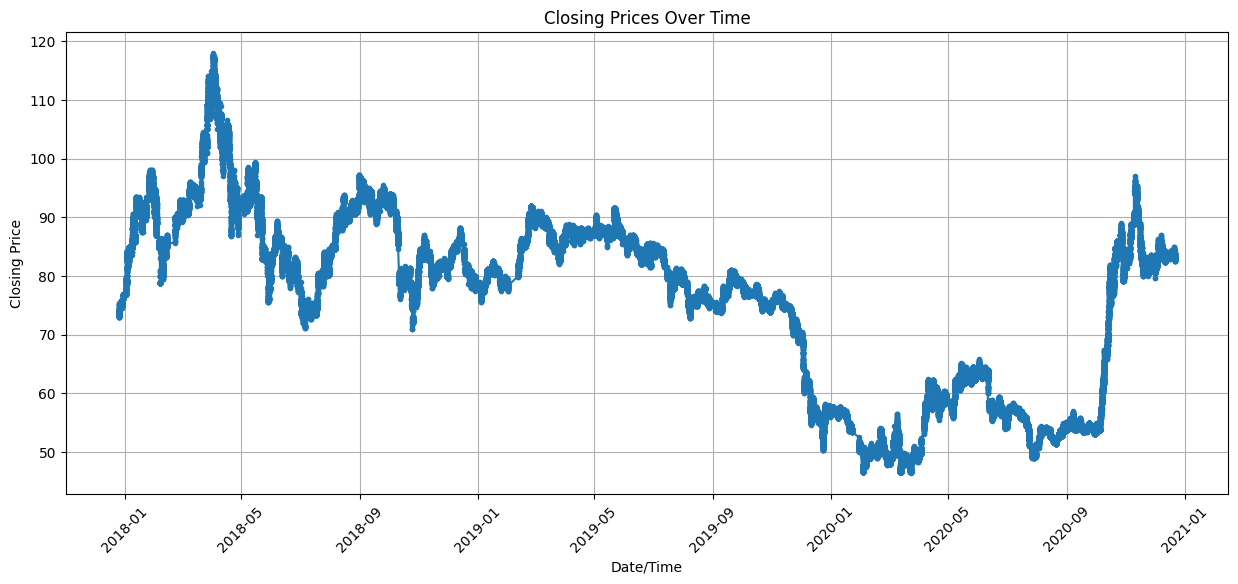

In [9]:
specific_df['Date/Time'] = pd.to_datetime(specific_df['Date/Time'])

plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date/Time'], specific_df['Close'], marker='.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date/Time')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

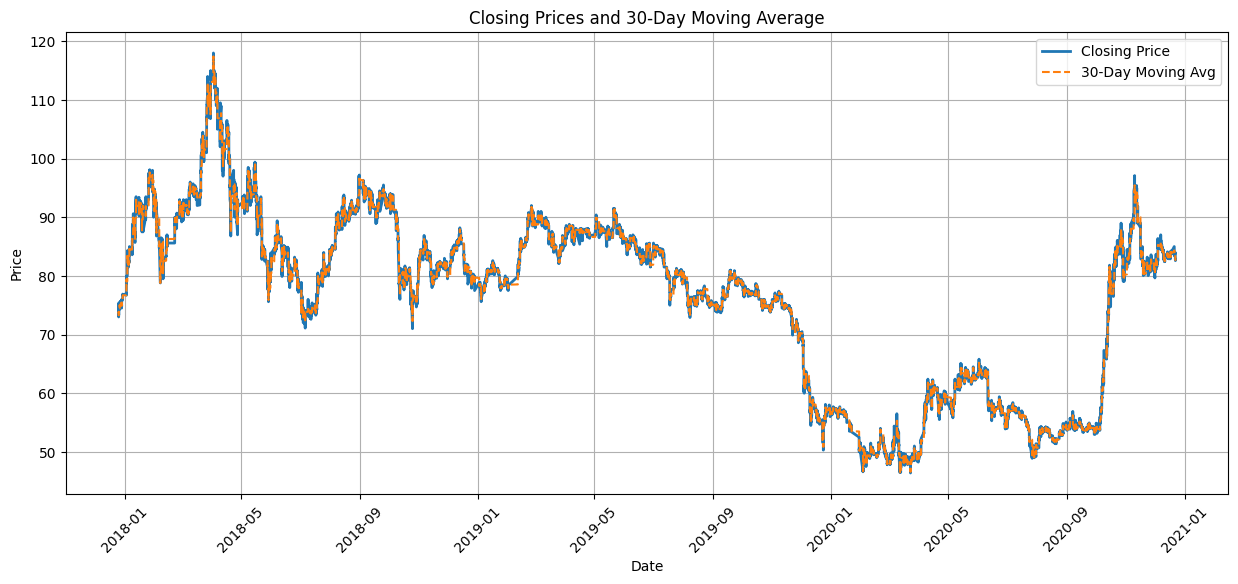

In [10]:
window = 30
plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date/Time'], specific_df['Close'], label='Closing Price', linewidth=2)
plt.plot(specific_df['Date/Time'], specific_df['Close'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

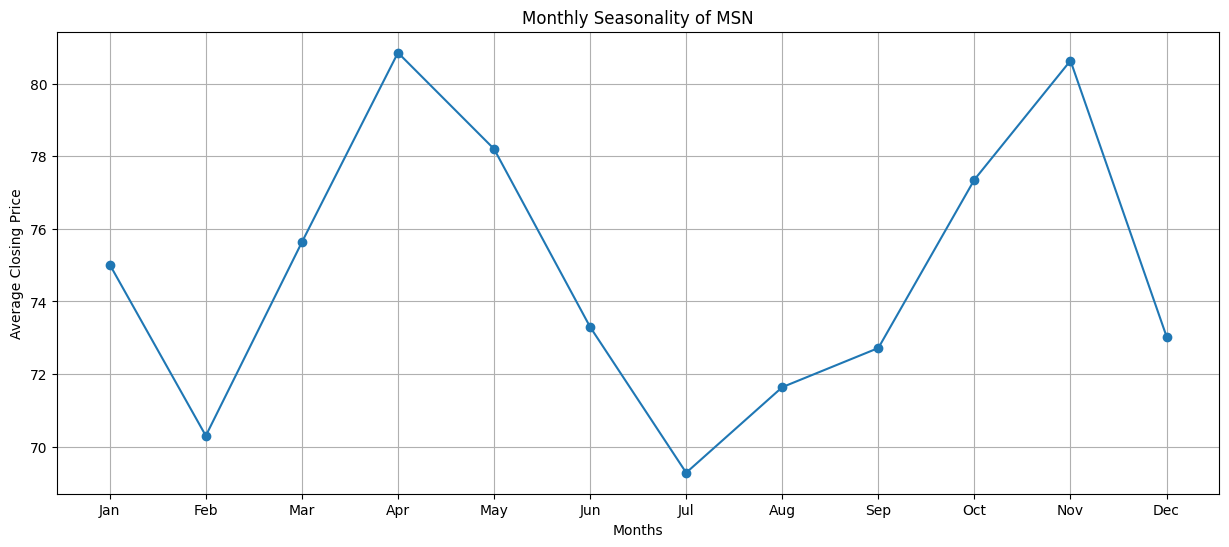

In [11]:
# Monthly Seasonality of Closing Prices
specific_df['Month'] = specific_df['Date/Time'].dt.month

monthly_average = specific_df.groupby('Month')['Close'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of MSN')
plt.xlabel('Months')
plt.ylabel('Average Closing Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

Từ hình ta thấy được rằng giá trị close sẽ cao nhất vào tháng 4 và tháng 11 và thấp nhất vào tháng 7

In [12]:
specific_df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Month
0,MSN,2017-12-25 09:15:00,73.1,73.1,73.1,73.1,4210,12
1,MSN,2017-12-25 09:16:00,73.0,73.0,73.0,73.0,5000,12
2,MSN,2017-12-25 09:18:00,73.5,73.5,73.5,73.5,210,12
3,MSN,2017-12-25 09:20:00,73.2,73.5,73.1,73.1,2050,12
4,MSN,2017-12-25 09:21:00,73.0,73.0,73.0,73.0,1380,12


In [13]:
#thực hiện lấy cột giá trị close để huấn luyên và dự đoán
new_df = specific_df.reset_index()['Close']

##3.3 Normalizing and prepare data


In [14]:
# thực hiện chuẩn hóa dữ liệu sử dụng  MinMaxScaler để đưa các giá trị về miền (0,1)
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [15]:
# chia các tập train và text
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

Ở đây ta sẽ thực hiện chia dữ liệu đầu vào và nhãn như sau:


*   Ta thực hiện lấy một chuỗi các giá trị trước đó trong qua khứ để làm dữ liệu đầu vào và nhãn sẽ là ngày tiếp theo


> vd: X (dữ liệu đầu vào) là các giá trị '**Close**' của 10 ngày trước đó và Y(nhãn) sẽ là giá trị của ngày thứ 11(giá trị cần phải dự đoán)






In [16]:
#n_past là khoảng thời gian trước đó ta muốn lấy để làm dữ liệu đầu vào
n_past = 10

# nếu n_past là 10 thì x_train là khoảng giá trị (0,9) và y_train là giá trị thứ 10
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train
print(y_train.shape)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

(108273,)


In [17]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(108273, 10)
(108273,)


Testing set size:-
(27061, 10)
(27061,)


(None, None)

Với bài toán này ta sẽ áp dụng mô hình phổ biến cho các loại bài toán này, LSTM

> Kích thước của dữ liệu mà mô hình LSTM yêu cầu như sau:
  * Dữ liệu thường có kích thước là (số mẫu, số bước thời gian, số đặc trưng).

  1. số mẫu là: số lượng chuỗi thời gian có sẵn để huấn luyện mô hình.
  2. số bước thời gian là: số lượng điểm dữ liệu trong mỗi chuỗi thời gian.
  3. số đặc trưng là: số lượng biến động (ví dụ: giá cổ phiếu, nhiệt độ) được quan sát tại mỗi bước thời gian.



In [18]:
# Reshape input data for LSTM([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 4.Model training


In [19]:

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [21]:
model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

In [22]:
# tạo file file checkpoin để lưu lại trọng số tốt nhất của mô hình
checkpoints = ModelCheckpoint(filepath = 'my_weights.h5', save_best_only = True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

Ở đây ta thêm các model có sẵn của LinearRegression và MLPRegressor để thực hiện so sanh với model ta đã tạo

In [23]:
models = {}

model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=50,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])
models['LSTM'] = model

X_train_2 = X_train.reshape((X_train.shape[0], -1))
X_test_2 = X_test.reshape((X_test.shape[0], -1))
X_train_2.shape, X_test_2.shape

model = LinearRegression().fit(X_train_2, y_train,)
models['LinearRegression'] = model

model = MLPRegressor(hidden_layer_sizes=(200, 100), activation='relu').fit(X_train_2, y_train,)
models['MLPRegressor'] = model

Epoch 1/50
3384/3384 [==============================] - 50s 11ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 1.1931e-04 - val_root_mean_squared_error: 0.0109
Epoch 2/50
3384/3384 [==============================] - 29s 9ms/step - loss: 4.2001e-04 - root_mean_squared_error: 0.0205 - val_loss: 1.5062e-04 - val_root_mean_squared_error: 0.0123
Epoch 3/50
3384/3384 [==============================] - 32s 9ms/step - loss: 3.6504e-04 - root_mean_squared_error: 0.0191 - val_loss: 1.7168e-04 - val_root_mean_squared_error: 0.0131
Epoch 4/50
3384/3384 [==============================] - 30s 9ms/step - loss: 3.4501e-04 - root_mean_squared_error: 0.0186 - val_loss: 8.4328e-05 - val_root_mean_squared_error: 0.0092
Epoch 5/50
3384/3384 [==============================] - 29s 9ms/step - loss: 3.4443e-04 - root_mean_squared_error: 0.0186 - val_loss: 3.2984e-05 - val_root_mean_squared_error: 0.0057
Epoch 6/50
3384/3384 [==============================] - 29s 9ms/step - loss: 3.3271e-04 

846/846 [==============================] - 3s 3ms/step


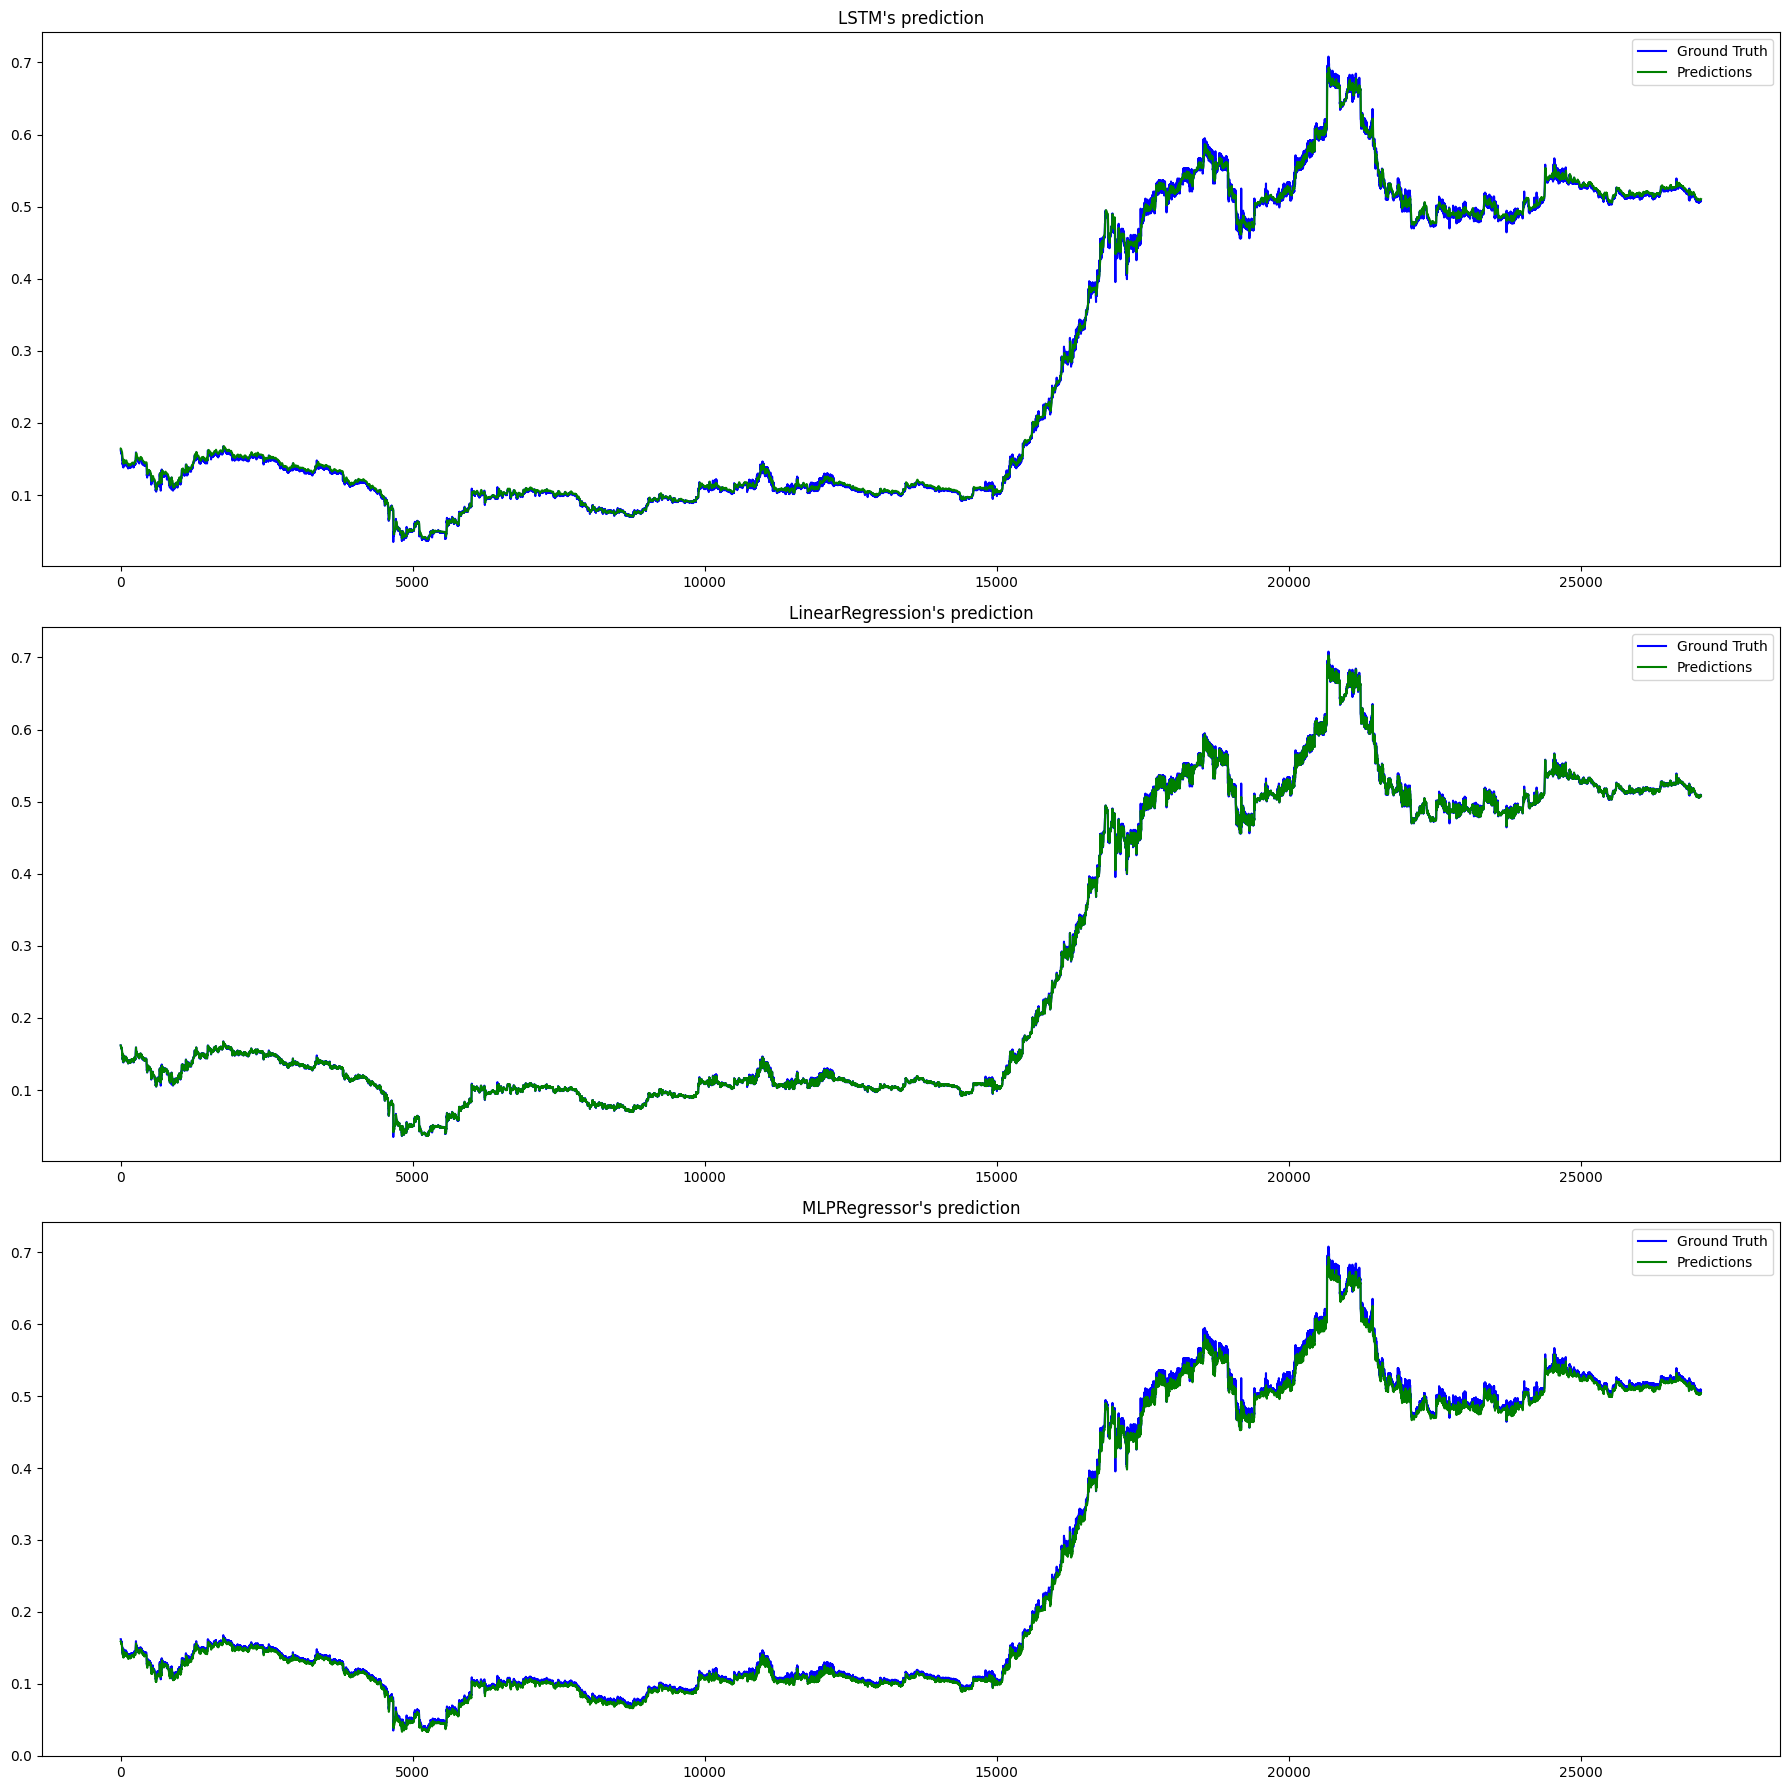

In [24]:
results = []
names = ['LSTM', 'LinearRegression', 'MLPRegressor']
fig, axs = plt.subplots(3, figsize=(18, 18))

for i, name in enumerate(names):
    if name == 'LSTM':
        predictions = models[name].predict(X_test)
    else:
        predictions = models[name].predict(X_test_2)

    axs[i].plot(y_test, c='b', label='Ground Truth')
    axs[i].plot(predictions, c='g', label='Predictions')
    axs[i].set_title("{}'s prediction".format(name))
    axs[i].legend()

    rs_item = {"Model": name, "RMSE": mean_squared_error(y_test, predictions)}
    results.append(rs_item)

plt.tight_layout()
plt.show()

In [25]:
table = pd.DataFrame(results)
table.set_index('Model')
table = table.sort_values(by='RMSE', ascending=True)
table = table.reset_index(drop=True)
table = table.style.highlight_max(subset='RMSE', color='black')
table

,Model,RMSE
0,LinearRegression,0.000013
1,LSTM,0.000018
2,MLPRegressor,0.000026


In [26]:
import seaborn as sns

846/846 [==============================] - 3s 3ms/step


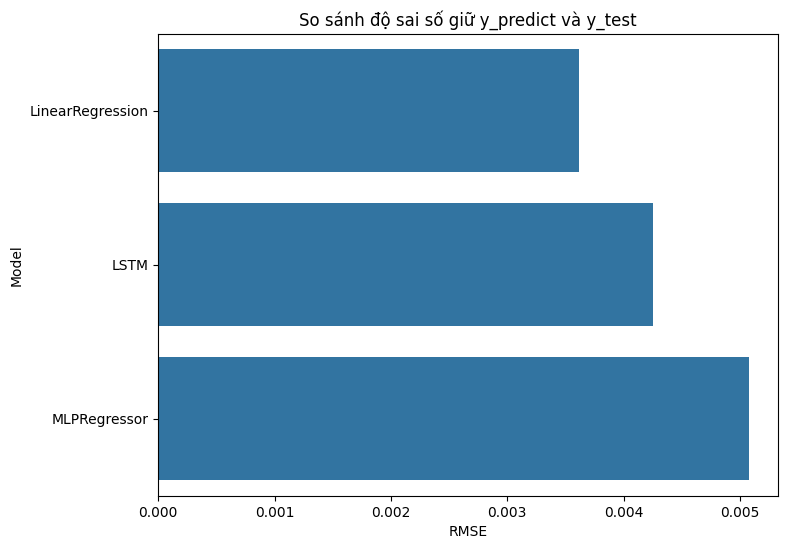

In [27]:
results = []

for name, model in models.items():
    if name == 'LSTM':
        predictions = model.predict(X_test)
    else:
        predictions = model.predict(X_test_2)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rs_item = {"Model": name, "RMSE": rmse}
    results.append(rs_item)

table = pd.DataFrame(results)
table = table.sort_values(by='RMSE', ascending=True)
table.reset_index(drop=True, inplace=True)

plt.figure(figsize=(8, 6))
sns.barplot(data=table, x='RMSE', y='Model')
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.title('So sánh độ sai số giữ y_predict và y_test')
plt.show()

Với kết quả trên ta thấy được model ta tạo khá tốt và không thua kém so với 2 model kia

# 5.Predict

In [28]:
models

{'LSTM': <keras.src.engine.sequential.Sequential at 0x7acb0c738fd0>,
 'LinearRegression': LinearRegression(),
 'MLPRegressor': MLPRegressor(hidden_layer_sizes=(200, 100))}

In [29]:
#Chọn model để thực hiện predict
model = models['LSTM']

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [31]:
#Thực hiện predict và so kết quả với y_test
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

846/846 [==============================] - 2s 3ms/step


In [32]:
for i in range(10):
  print(test_predict[i], y_test[i])

[0.16450685] 0.16201117318435765
[0.16454482] 0.1606145251396649
[0.16445881] 0.1606145251396649
[0.16436401] 0.1606145251396649
[0.16428441] 0.1606145251396649
[0.16416791] 0.1606145251396649
[0.16399658] 0.15921787709497215
[0.16370621] 0.1578212290502794
[0.16327772] 0.15921787709497215
[0.16295615] 0.15921787709497215


<function matplotlib.pyplot.show(close=None, block=None)>

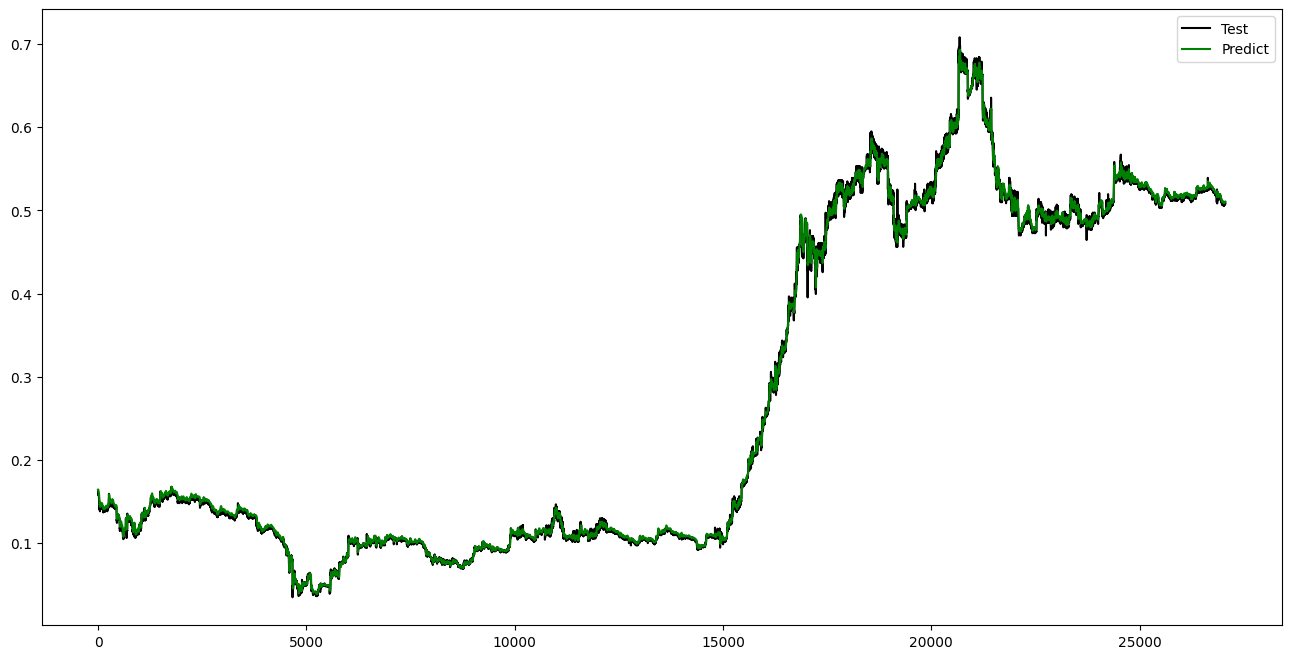

In [33]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label='Test')
plt.plot(test_predict, color = 'green', label='Predict')
plt.legend()
plt.show

## 5.1.Thực hiện predict giá cổ phiếu cho 10 ngày tiếp theo và biến động cổ phiếu

Đầu tiên ta sẽ thực hiện lấy cột dữ liệu cuối cùng của tập X_test làm dữ liệu đầu vào dể tiến hành dự đoán giá trị cho những ngày tiếp theo => giá trị cuối cùng của cột dữ liệu ta lấy chính là giá trị cổ phiếu hiện tại và các giá trị được dự đoán là các giá trị tiếp theo.

In [34]:
# thực hiện lấy cột dữ liệu cuối của tập text để thực hiện predict giá cổ phiếu cho những ngày kế tiếp
last_sequence = X_test[-1]

In [35]:
# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, n_past, 1)

In [36]:
last_sequence

array([[[0.50698324],
        [0.50698324],
        [0.50977654],
        [0.50698324],
        [0.50837989],
        [0.50837989],
        [0.50837989],
        [0.50837989],
        [0.50837989],
        [0.50837989]]])

In [37]:
#giá trị cổ phiếu hiện tại sẽ là giá trị cuối cùng của cột dữ liệu đã lấy ở trên
last_price = last_sequence[0, -1, 0]
last_price

0.5083798882681565

In [38]:
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])
    '''sau khi đã predict kết quả ngày tiếp theo, ta dịch chuyển (shift)
    dãy thời gian sang phải một bước, chuẩn bị cho việc cập nhật giá trị mới vào cuối dãy để dự đoán cho các ngày tiếp theo '''
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

1/1 [==============================] - 0s 35ms/step


In [39]:
predictions_next_10_days

[0.51056063,
 0.51107717,
 0.51159024,
 0.51201034,
 0.5125172,
 0.51301754,
 0.5135462,
 0.51409364,
 0.51465404,
 0.5152247]

In [40]:
# chuyển các giá trị đã chuẩn hóa về giá trị gốc
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))
predictions_next_10_days

array([[82.95614 ],
       [82.993126],
       [83.02986 ],
       [83.059944],
       [83.09624 ],
       [83.13206 ],
       [83.169914],
       [83.20911 ],
       [83.24923 ],
       [83.29009 ]], dtype=float32)

In [41]:
last_price = scaler.inverse_transform(np.array(last_price).reshape(-1, 1))
last_price

array([[82.8]])

In [42]:
print("Gía dự đoán trong 10 ngày tới:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Ngày {i}: Gía dự đoán = {prediction[0]}")

Gía dự đoán trong 10 ngày tới:
Ngày 1: Gía dự đoán = 82.95613861083984
Ngày 2: Gía dự đoán = 82.99312591552734
Ngày 3: Gía dự đoán = 83.02986145019531
Ngày 4: Gía dự đoán = 83.05994415283203
Ngày 5: Gía dự đoán = 83.09623718261719
Ngày 6: Gía dự đoán = 83.1320571899414
Ngày 7: Gía dự đoán = 83.16991424560547
Ngày 8: Gía dự đoán = 83.2091064453125
Ngày 9: Gía dự đoán = 83.24922943115234
Ngày 10: Gía dự đoán = 83.29009246826172


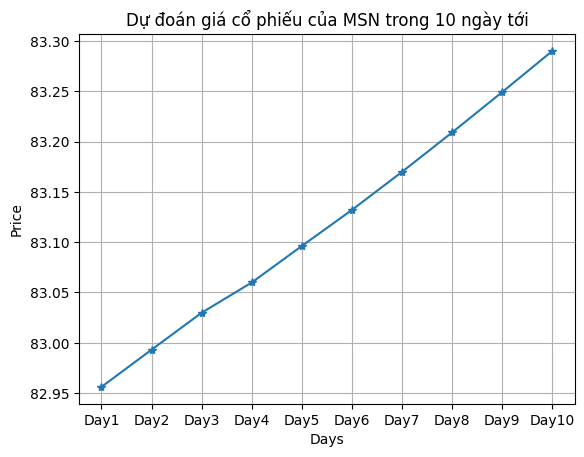

In [43]:
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Dự đoán giá cổ phiếu của MSN trong 10 ngày tới')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()

In [44]:
#Biến động giá cổ phiếu trong 10 ngày tới
price_differences = predictions_next_10_days - last_price

In [45]:
price_differences

array([[0.15613861],
       [0.19312592],
       [0.22986145],
       [0.25994415],
       [0.29623718],
       [0.33205719],
       [0.36991425],
       [0.40910645],
       [0.44922943],
       [0.49009247]])

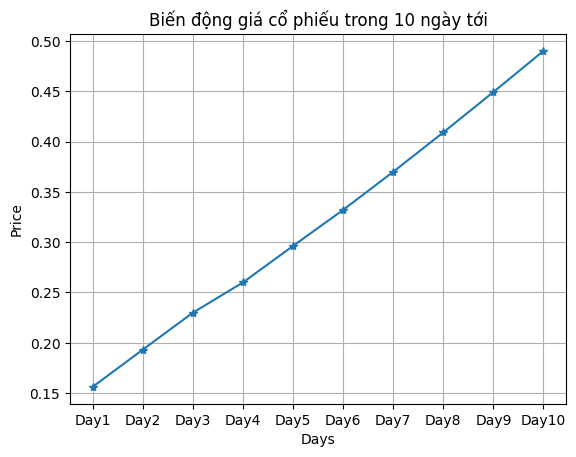

In [46]:
plt.plot(price_differences, marker='*')
plt.title(f'Biến động giá cổ phiếu trong 10 ngày tới')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()